<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LR-test" data-toc-modified-id="LR-test-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LR test</a></span></li><li><span><a href="#RFR-test" data-toc-modified-id="RFR-test-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RFR test</a></span></li><li><span><a href="#CBR-test" data-toc-modified-id="CBR-test-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CBR test</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV 

from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
import catboost as cb

from tqdm import tqdm

In [59]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [60]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Анализ

In [61]:
data[data.duplicated()]

,num_orders
datetime,
2018-03-01 15:00:00,66
2018-03-01 16:00:00,43
2018-03-01 21:00:00,66
2018-03-02 03:00:00,64
2018-03-02 06:00:00,11
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Дубликатов нет**

In [62]:
data.isnull().sum()

num_orders    0
dtype: int64

**Пропусков нет**

Text(0, 0.5, 'Кол-во заказов')

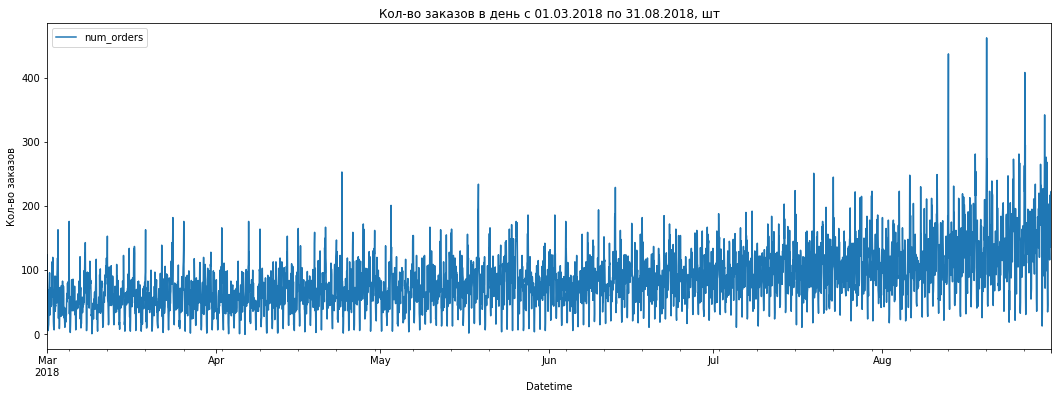

In [63]:
data.plot(figsize=(18, 6))
plt.title('Кол-во заказов в день с 01.03.2018 по 31.08.2018, шт')
plt.xlabel('Datetime')
plt.ylabel('Кол-во заказов')

**Как видим, наибольшее число заказов - в августе. Это неудивительно - многие возвращаются из отпусков, студенты из своих городов и т.д. Видно, что в некоторые временные отрезки количество заказов довольно сильно превышает остальные. Это могут быть выбросы, а может связано с тем, что какие-то конкретные рейсы прилетают именно в это время. Пока не будем удалять эти данные**

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [65]:
print('Start of the period:', data.index.min())
print('End of the period:', data.index.max())
print('Time period:', data.index.max() - data.index.min())
print()
data.describe()

Start of the period: 2018-03-01 00:00:00
End of the period: 2018-08-31 23:00:00
Time period: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Протяженность рассматриваемого временного отрезка - 183 дня и 23 часа**

<AxesSubplot:xlabel='datetime'>

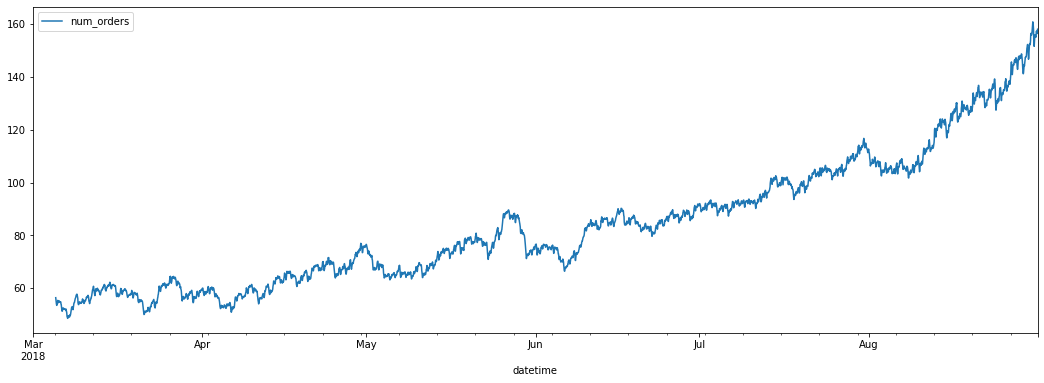

In [66]:
data.rolling(100).mean().plot(figsize=(18, 6))

<AxesSubplot:xlabel='datetime'>

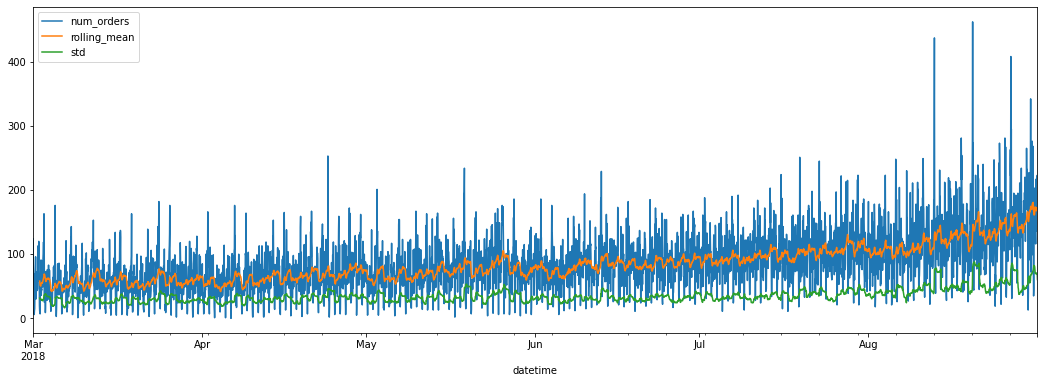

In [67]:
data_pl = data.copy()
data_pl['rolling_mean'] = data_pl.rolling(30).mean()
data_pl['std'] = data_pl['num_orders'].rolling(30).std()
data_pl.plot(figsize=(18, 6))

**Тренд восходящий, т.е. в период с марта по август наблюдаем постепенный прирост числа заказов**

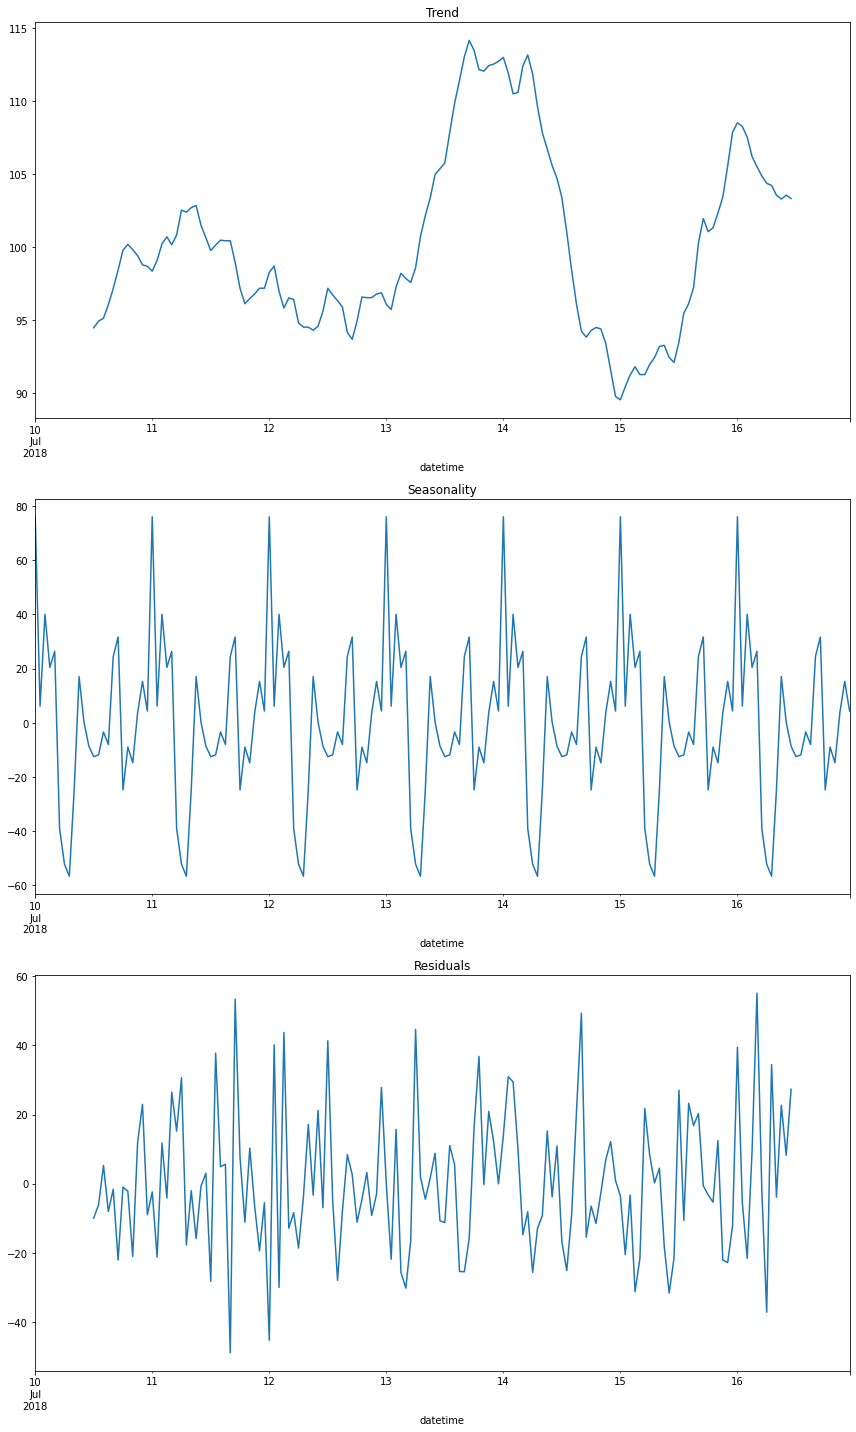

In [68]:
one_week = seasonal_decompose(data['2018-07-10':'2018-07-16'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
one_week.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
one_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
one_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Имеется так называемая суточная сезонность - вечером наблюдается наибольшее число заказов (взята рандомная неделя за период 10.07.2023 - 16.07.2023)**

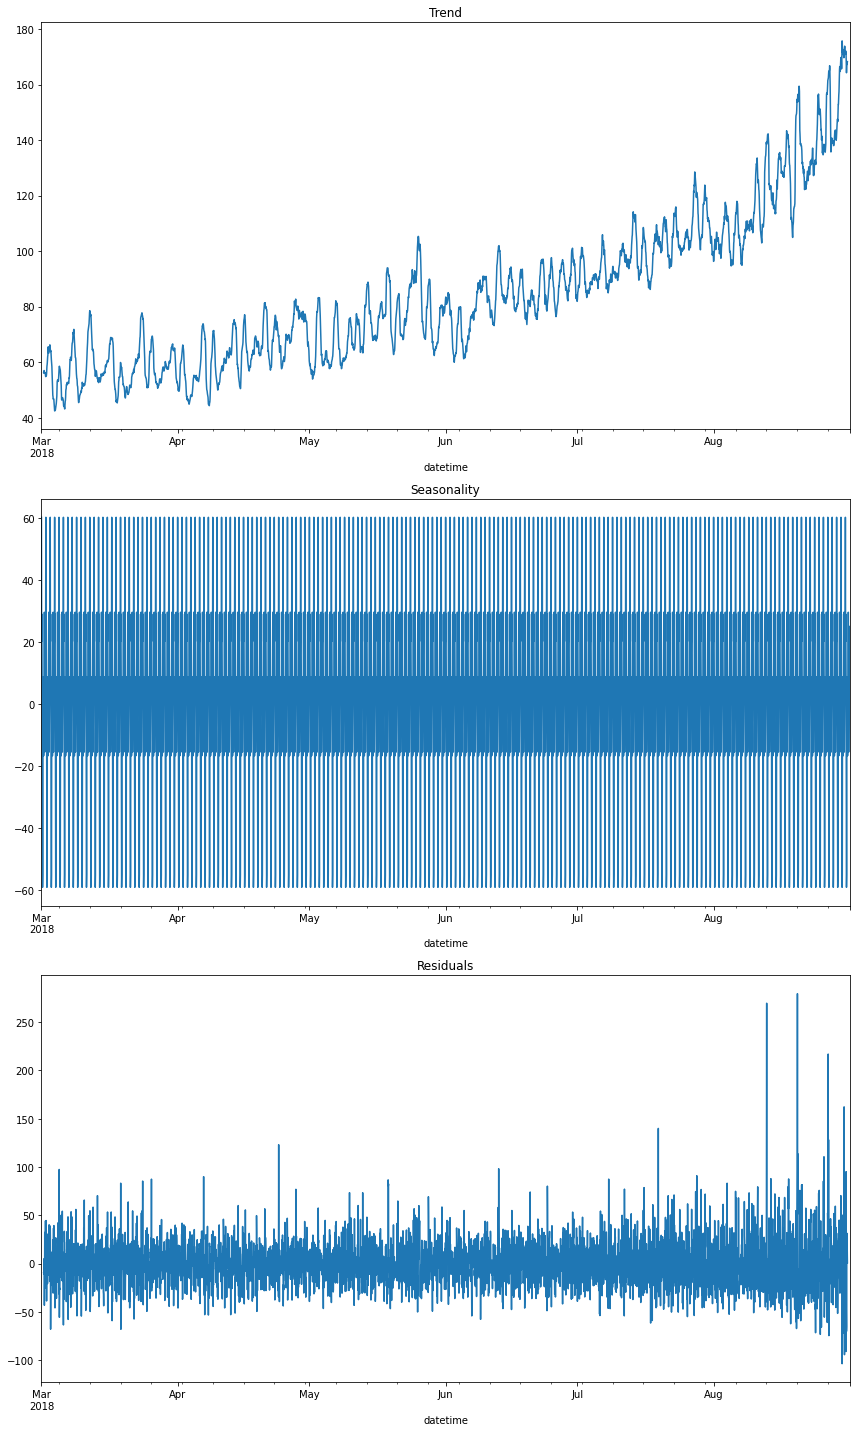

In [69]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


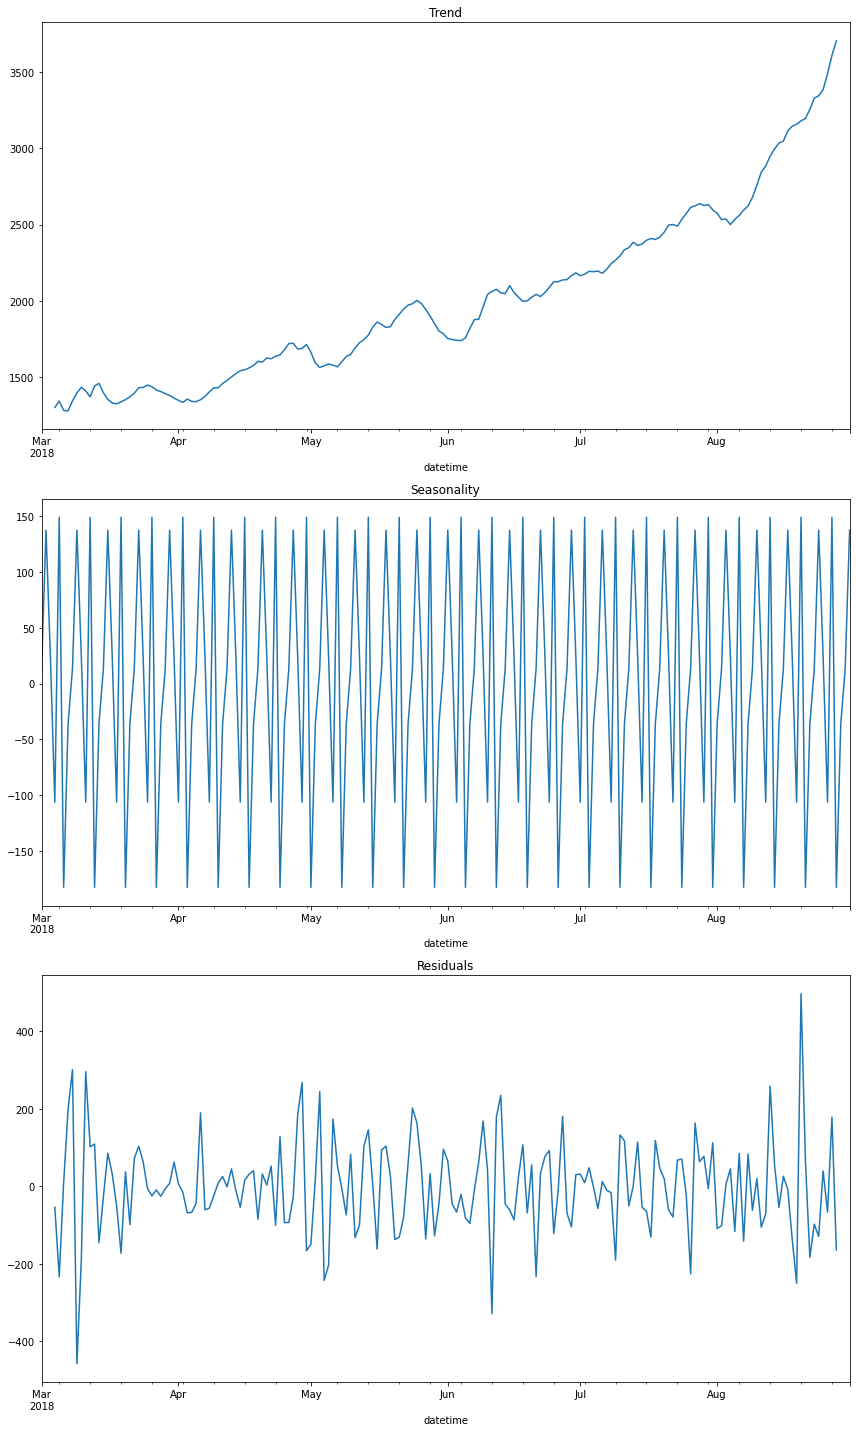

In [70]:
data_week = data.resample('1D').sum() 
decomposed_week = seasonal_decompose(data_week)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Общий вывод:** 

**1. Число заказов такси постепенно увеличивается с марта по август, что может говорить либо о том, что в летний сезон услугами такси пользуются чаще (но такое подойдет скорее в частных случаях, например, если речь идет о курортных городах), либо, что бизнес у "Четенького такси" растет (более вероятно);**

**2. Вечером такси заказывают чаще всего (вполне правдоподобно);**

**3. Доля остатков +- на протяжении временного отрезка одинаковая.**

## Обучение

In [71]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

**Нам необходимо создать признаки для обучения моделей. Сделаем это через функции, описанную выше**

In [72]:
make_features(data, 24, 100)

In [74]:
data.head(15)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,5,0,4,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,5,0,5,34.0,51.0,32.0,176.0,86.0,68.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,5,0,6,16.0,34.0,51.0,32.0,176.0,86.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,5,0,7,3.0,16.0,34.0,51.0,32.0,176.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,5,0,8,14.0,3.0,16.0,34.0,51.0,32.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67
2018-03-05 09:00:00,59,5,0,9,31.0,14.0,3.0,16.0,34.0,51.0,...,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,53.55
2018-03-05 10:00:00,50,5,0,10,59.0,31.0,14.0,3.0,16.0,34.0,...,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,54.08
2018-03-05 11:00:00,62,5,0,11,50.0,59.0,31.0,14.0,3.0,16.0,...,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,54.46
2018-03-05 12:00:00,85,5,0,12,62.0,50.0,59.0,31.0,14.0,3.0,...,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,54.93


In [75]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, \
                                                                            random_state=777, shuffle=False)

### LinearRegression

In [76]:
time_1 = time.time()
cv_LR = TimeSeriesSplit(n_splits=3).split(features_train)
model_LR = LinearRegression().fit(features_train, target_train)
score_lr = cross_val_score(model_LR, features_train, target_train, scoring = 'neg_mean_squared_error', cv = cv_LR)
time_2 = time.time()
time_LR = time_2 - time_1
print('Качество модели LinearRegression на кросс-валидации:', round(np.mean(-score_lr)**0.5, 2))
print('Время обучения LinearRegression: %s секунд' % time_LR)

Качество модели LinearRegression на кросс-валидации: 28.69
Время обучения LinearRegression: 0.6007473468780518 секунд


### RandomForestRegressor

In [77]:
# time_1 = time.time()
# model_RFR = RandomForestRegressor(criterion = "mse", random_state=777, n_estimators = 100, n_jobs=-1) \
# .fit(features_train, target_train)
# predictions_RFR = model_RFR.predict(features_train)
# time_2 = time.time()
# time_RFR = time_2 - time_1
# RMSE_RFR = (mean_squared_error(target_train, predictions_RFR))**.5
# print("Время обучения RandomForestRegressor: %s секунд" % time_RFR)
# print("RMSE для RFR:", RMSE_RFR)

In [78]:
%%time

cv_RFR = TimeSeriesSplit(n_splits=3).split(features_train)
model_RFR = RandomForestRegressor()
param_RFR = { 'n_estimators': range(5, 30, 5),
              'max_depth': range(1, 15, 2),
              'min_samples_leaf': range(1, 5), 
              'min_samples_split': range(2, 8, 2) }

grid_RFR = GridSearchCV(model_RFR, param_RFR, scoring = 'neg_mean_squared_error', cv = cv_RFR) \
.fit(features_train, target_train)

# прогон кода занимает 4-5 мин у меня. Он если что работает))

CPU times: user 4min 8s, sys: 720 ms, total: 4min 8s
Wall time: 4min 9s


In [79]:
param_RFR = grid_RFR.best_params_
print(param_RFR)

{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 25}


### CatBoostRegressor

In [80]:
# time_1 = time.time()
# model_CBR = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=777) \
# .fit(features_train, target_train, verbose=100, early_stopping_rounds=50)
# predictions_CBR = model_CBR.predict(features_train)
# time_2 = time.time()
# time_CatBoost = time_2 - time_1
# RMSE_CBR = (mean_squared_error(target_train, predictions_CBR))**.5
# print("Время обучения CatBoostRegressor: %s секунд" % time_CatBoost)
# print("RMSE для CBR:", RMSE_CBR)

In [81]:
%%time

cv_CBR = TimeSeriesSplit(n_splits=3).split(features_train)
model_CBR = cb.CatBoostRegressor()
param_CBR = { 'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10] }

grid_CBR = GridSearchCV(model_CBR, param_CBR, scoring= 'neg_mean_squared_error', cv=cv_CBR) \
.fit(features_train, target_train, verbose = 100)

0:	learn: 28.8593976	total: 2.04ms	remaining: 2.04s
100:	learn: 17.8396881	total: 229ms	remaining: 2.04s
200:	learn: 16.1729514	total: 432ms	remaining: 1.72s
300:	learn: 14.9776653	total: 617ms	remaining: 1.43s
400:	learn: 13.7774912	total: 826ms	remaining: 1.23s
500:	learn: 12.7405465	total: 1.02s	remaining: 1.02s
600:	learn: 11.8897883	total: 1.2s	remaining: 799ms
700:	learn: 11.0971906	total: 1.38s	remaining: 588ms
800:	learn: 10.3968847	total: 1.54s	remaining: 384ms
900:	learn: 9.7547033	total: 1.75s	remaining: 193ms
999:	learn: 9.1418387	total: 1.92s	remaining: 0us
0:	learn: 31.8971050	total: 2.2ms	remaining: 2.19s
100:	learn: 20.2427358	total: 253ms	remaining: 2.25s
200:	learn: 18.4956229	total: 476ms	remaining: 1.89s
300:	learn: 17.4280984	total: 699ms	remaining: 1.62s
400:	learn: 16.6146324	total: 1.02s	remaining: 1.52s
500:	learn: 15.8494135	total: 1.29s	remaining: 1.28s
600:	learn: 15.2359642	total: 1.53s	remaining: 1.01s
700:	learn: 14.6620123	total: 1.78s	remaining: 761ms
8

In [82]:
param_CBR = grid_CBR.best_params_
print(param_CBR)

{'depth': 4, 'learning_rate': 0.03}


## Тестирование

### LR test

In [83]:
predictions_LR_test = model_LR.predict(features_test)
RMSE_LR_test = (mean_squared_error(target_test, predictions_LR_test))**.5
print('RMSE для LR:', RMSE_LR_test)

RMSE для LR: 45.16551674881993


### RFR test

In [84]:
# predictions_RFR_test = model_RFR.fit(features_train, target_train).predict(features_test)
# RMSE_RFR_test = (mean_squared_error(target_test, predictions_RFR_test))**.5
# print('RMSE для RFR:', RMSE_RFR_test)

In [86]:
RFR_test = RandomForestRegressor(random_state = 777, max_depth=param_RFR['max_depth'], \
                                      min_samples_leaf = param_RFR['min_samples_leaf'], \
                                     min_samples_split = param_RFR['min_samples_split'], \
                                     n_estimators = param_RFR['n_estimators']).fit(features_train, target_train)
RFR_test_pred = RFR_test.predict(features_test)
RMSE_RFR_test = (mean_squared_error(target_test, RFR_test_pred))**.5
print('RMSE для RFR:', RMSE_RFR_test)

RMSE для RFR: 44.06021976488705


### CBR test

In [87]:
# predictions_CBR_test = model_CBR.fit(features_train, target_train).predict(features_test)
# RMSE_CBR_test = (mean_squared_error(target_test, predictions_CBR_test))**.5
# print('RMSE для CBR:', RMSE_CBR_test)

In [88]:
CBR_test = cb.CatBoostRegressor(learning_rate=param_CBR['learning_rate'],
                                depth=param_CBR['depth']).fit(features_train, target_train, verbose=100)
CBR_test_pred = CBR_test.predict(features_test)
RMSE_CBR_test = (mean_squared_error(target_test, CBR_test_pred))**.5
print('RMSE для CBR:', RMSE_CBR_test)

0:	learn: 38.1765520	total: 2.85ms	remaining: 2.85s
100:	learn: 24.1983626	total: 267ms	remaining: 2.37s
200:	learn: 22.7888340	total: 540ms	remaining: 2.15s
300:	learn: 21.7469412	total: 809ms	remaining: 1.88s
400:	learn: 20.8383617	total: 1.08s	remaining: 1.61s
500:	learn: 20.0446383	total: 1.34s	remaining: 1.34s
600:	learn: 19.3789821	total: 1.65s	remaining: 1.1s
700:	learn: 18.8010772	total: 1.91s	remaining: 817ms
800:	learn: 18.2792343	total: 2.17s	remaining: 540ms
900:	learn: 17.8117666	total: 2.47s	remaining: 272ms
999:	learn: 17.3876416	total: 2.73s	remaining: 0us
RMSE для CBR: 41.52053437596481


In [89]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('RMSE для проверки модели на адекватность:', (mean_squared_error(target_test, pred_previous))**.5)

RMSE для проверки модели на адекватность: 59.157061035605636


In [90]:
results_test = pd.DataFrame({'Model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
                              'Значение RMSE test': [RMSE_LR_test, RMSE_RFR_test, RMSE_CBR_test]})
results_test

,Model,Значение RMSE test
0,LinearRegression,45.165517
1,RandomForestRegressor,44.060220
2,CatBoostRegressor,41.520534


## Выводы

Было проведено исследование, связанное с прогнозированием кол-ва заказов такси в аэропортах на следующий час. Данные для моделей - информация о заказах такси в аэропортах с 1 марта по 31 августа 2018 года. Использовали модели линейной регрессии, случайного леса и CatBoost - все три на тестовой выборке показали RMSE < 48, что удовлетворяет условиям задачи. 

CatBoostRegressor - самая точная модель, т.к. она обладает наименьшим RMSE

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48